This is a prototype of a time series using ARIMA to predict energy consumption patterns.

This model uses a singular series of data over a period of 15 months to train and then predicts a further 12 months of data immediately after. The small number of observations reduce the accuracy of this model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
%matplotlib inline

In [2]:
# import data and set DateTime column as index
energy_data_frame = pd.read_csv('./data/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv', index_col='DateTime')

In [3]:
# set index for timeseries
energy_data_frame.index = pd.to_datetime(energy_data_frame.index, infer_datetime_format=True)

In [4]:
energy_data_frame = energy_data_frame.drop(['stdorToU', 'Acorn', 'Acorn_grouped'], axis=1)

In [5]:
# convert consumption data to numeric and append as consumption
energy_data_frame['consumption'] = pd.to_numeric(energy_data_frame['KWH/hh (per half hour) '], errors='coerce')

In [6]:
# remove old consumption data
energy_data_frame = energy_data_frame.drop(['KWH/hh (per half hour) '], axis=1)

In [7]:
# rotate to make each id into a series
energy_data_frame = energy_data_frame.pivot_table(values='consumption', index=['DateTime'], columns=['LCLid'] )

In [8]:
# convert to monthly sum
energy_data_frame = energy_data_frame.resample('m').sum()

In [9]:
energy_data_id34 = pd.DataFrame(index=energy_data_frame.index, columns=['MAC000034'])

In [10]:
energy_data_id34['MAC000034']  = energy_data_frame['MAC000034']

In [11]:
# create rolling averages SMA
energy_data_id34['6-month-SMA'] = energy_data_id34['MAC000034'].rolling(6).mean()
energy_data_id34['12-month-SMA'] = energy_data_id34['MAC000034'].rolling(12).mean()
energy_data_id34['12-month-STD'] = energy_data_id34['MAC000034'].rolling(12).std()

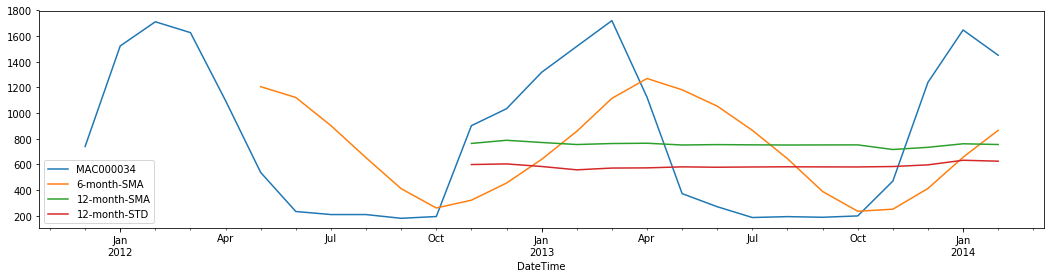

In [12]:
energy_data_id34.plot(figsize=(18, 4))

In [13]:
# take a look at some key points of our data
energy_data_id34.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MAC000034,27.0,818.590741,592.576460,181.013000,210.288000,739.998999,1383.942498,1719.521003
6-month-SMA,22.0,716.987856,343.936921,235.789833,412.062417,654.548667,1016.196542,1269.320000
12-month-SMA,16.0,755.592016,15.559518,716.587000,752.033937,755.014500,763.262708,788.354166
12-month-STD,16.0,588.562926,19.313873,558.416665,580.081951,581.724761,597.710725,632.865156


In [14]:
decomp = seasonal_decompose(energy_data_id34['MAC000034'])

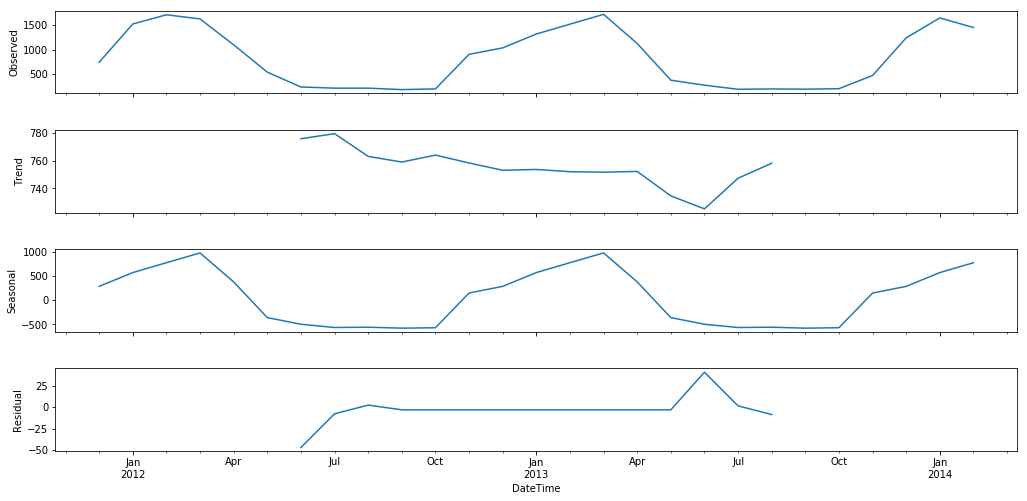

In [15]:
fig = decomp.plot()
fig.set_size_inches(16, 8)

In [16]:
# augmented dicky-fuller test
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dicky-Fuller Test')
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'N of observations']
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print('reject null hypothesis')
    else:
        print('failed to reject null hypothesis')

In [17]:
adf_check(energy_data_id34['MAC000034'])

Augmented Dicky-Fuller Test
ADF Test Statistic : -4.463656853014181
p-value : 0.00022861100025682872
# of lags : 7
N of observations : 19
reject null hypothesis


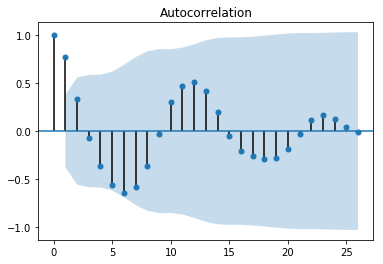

In [18]:
fig_result = plot_acf(energy_data_id34['MAC000034'])

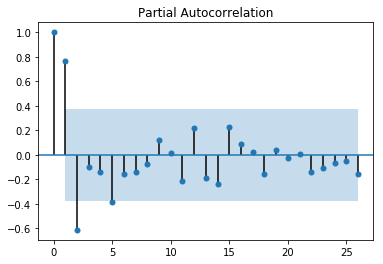

In [19]:
fig_result = plot_pacf(energy_data_id34['MAC000034'], method='ywmle')

In [20]:
# using seasonal ARIMA
model = sm.tsa.statespace.SARIMAX(energy_data_id34['MAC000034'].head(15), order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))

In [21]:
# setting starting params manually as data set is too small
start_params = [0, 0, 1.]
results = model.fit(start_params)

In [22]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          MAC000034   No. Observations:                   15
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                 -14.223
Date:                            Tue, 01 Jan 2019   AIC                             34.447
Time:                                    15:35:00   BIC                             30.526
Sample:                                12-31-2011   HQIC                            26.247
                                     - 02-28-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9961      7.538     -0.132      0.895     -15.770      13.778
ma.S.L12      -0.9054   1852.406   

c:\users\mrehm\anaconda3\envs\primary\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2194: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
c:\users\mrehm\anaconda3\envs\primary\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2199: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
c:\users\mrehm\anaconda3\envs\primary\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\mrehm\anaconda3\envs\primary\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\mrehm\anaconda3\envs\primary\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invali

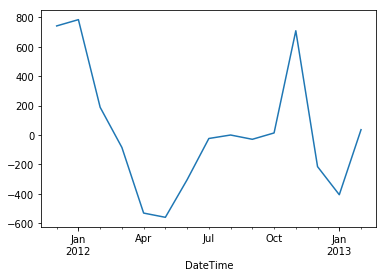

In [23]:
# small number of observations result in large errors
results.resid.plot()

In [24]:
energy_data_id34['Predicted'] = results.predict(start=15, end=27)

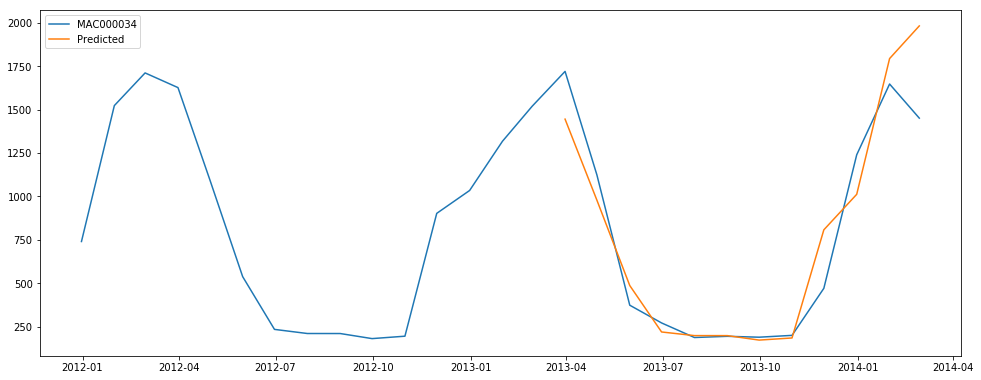

In [25]:
fig = plt.figure(figsize=(16, 6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(energy_data_id34['MAC000034'])
axes.plot(energy_data_id34['Predicted'].tail(12))
axes.legend()